### Link Prediction in Social Netowork

1. Разбиение графа на несколько компонент для изучения различий


2. Модель присутствия ребер в графе <br>
   2.1 Нахождение среди отсутствующих ребер 5 с самой большой согласно модели вероятностью присутствия <br>
   2.2 Восстановление ребер <br>
   2.3. Добавление в модель признака совпадения комьюнити для двух вершин <br>


3. Интерпретация мер центральности для данного графа

In [1]:
import json
full_friends = json.load(open("nodes_count.txt", "tr"))
full_graph = json.load(open("edges_new.txt", "tr"))
import networkx as nx
G = nx.Graph()
for i in full_friends:
    G.add_node(i["id"], name = i["first_name"]+" "+i["last_name"], sex = i["sex"], home_town = i.setdefault("home_town"), counters = i["counters"])
my_friends = list(nx.nodes(G))
for i in my_friends:
    if "items" in full_graph[str(i)]:
        for j in full_graph[str(i)]["items"]:
            if j in my_friends:
                G.add_edge(i, j)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_graph(g):
    with plt.xkcd():
        k = nx.degree(g)
        plt.figure(1, figsize=(60,45))
#         coord = nx.kamada_kawai_layout(g)
        coord = nx.nx.spring_layout(g,k=0.15,iterations=20)
#         labels={nd: g.nodes[nd]['name'] for (nd) in g.nodes()}
        nx.draw_networkx(g, pos=coord, nodelist=dict(k).keys(), node_size=[v*50 for v in dict(k).values()], 
                         font_size=17, node_color=list(dict(k).values()),  cmap=plt.cm.Blues)

### 1. Разбиение графа на несколько компонент для изучения различий

Разбиение - на каждом шаге удаляется ребро с наибольшим показателей betweenes, пока граф не разобьется не меньше чем на 3 отдельных компоненты.

* Изучается разница в распределении людей по выбранным признакам в получившихся комьюнити.

In [3]:
len(list(nx.connected_components(G)))

6

In [4]:
# из 6 компонент связности выбираем самую большую, так как остальные состоят из одной вершины,
# а мы хотим изучить крупные сообщества
largest_cc = max(nx.connected_components(G), key=len)
Gmain = G.subgraph(largest_cc)

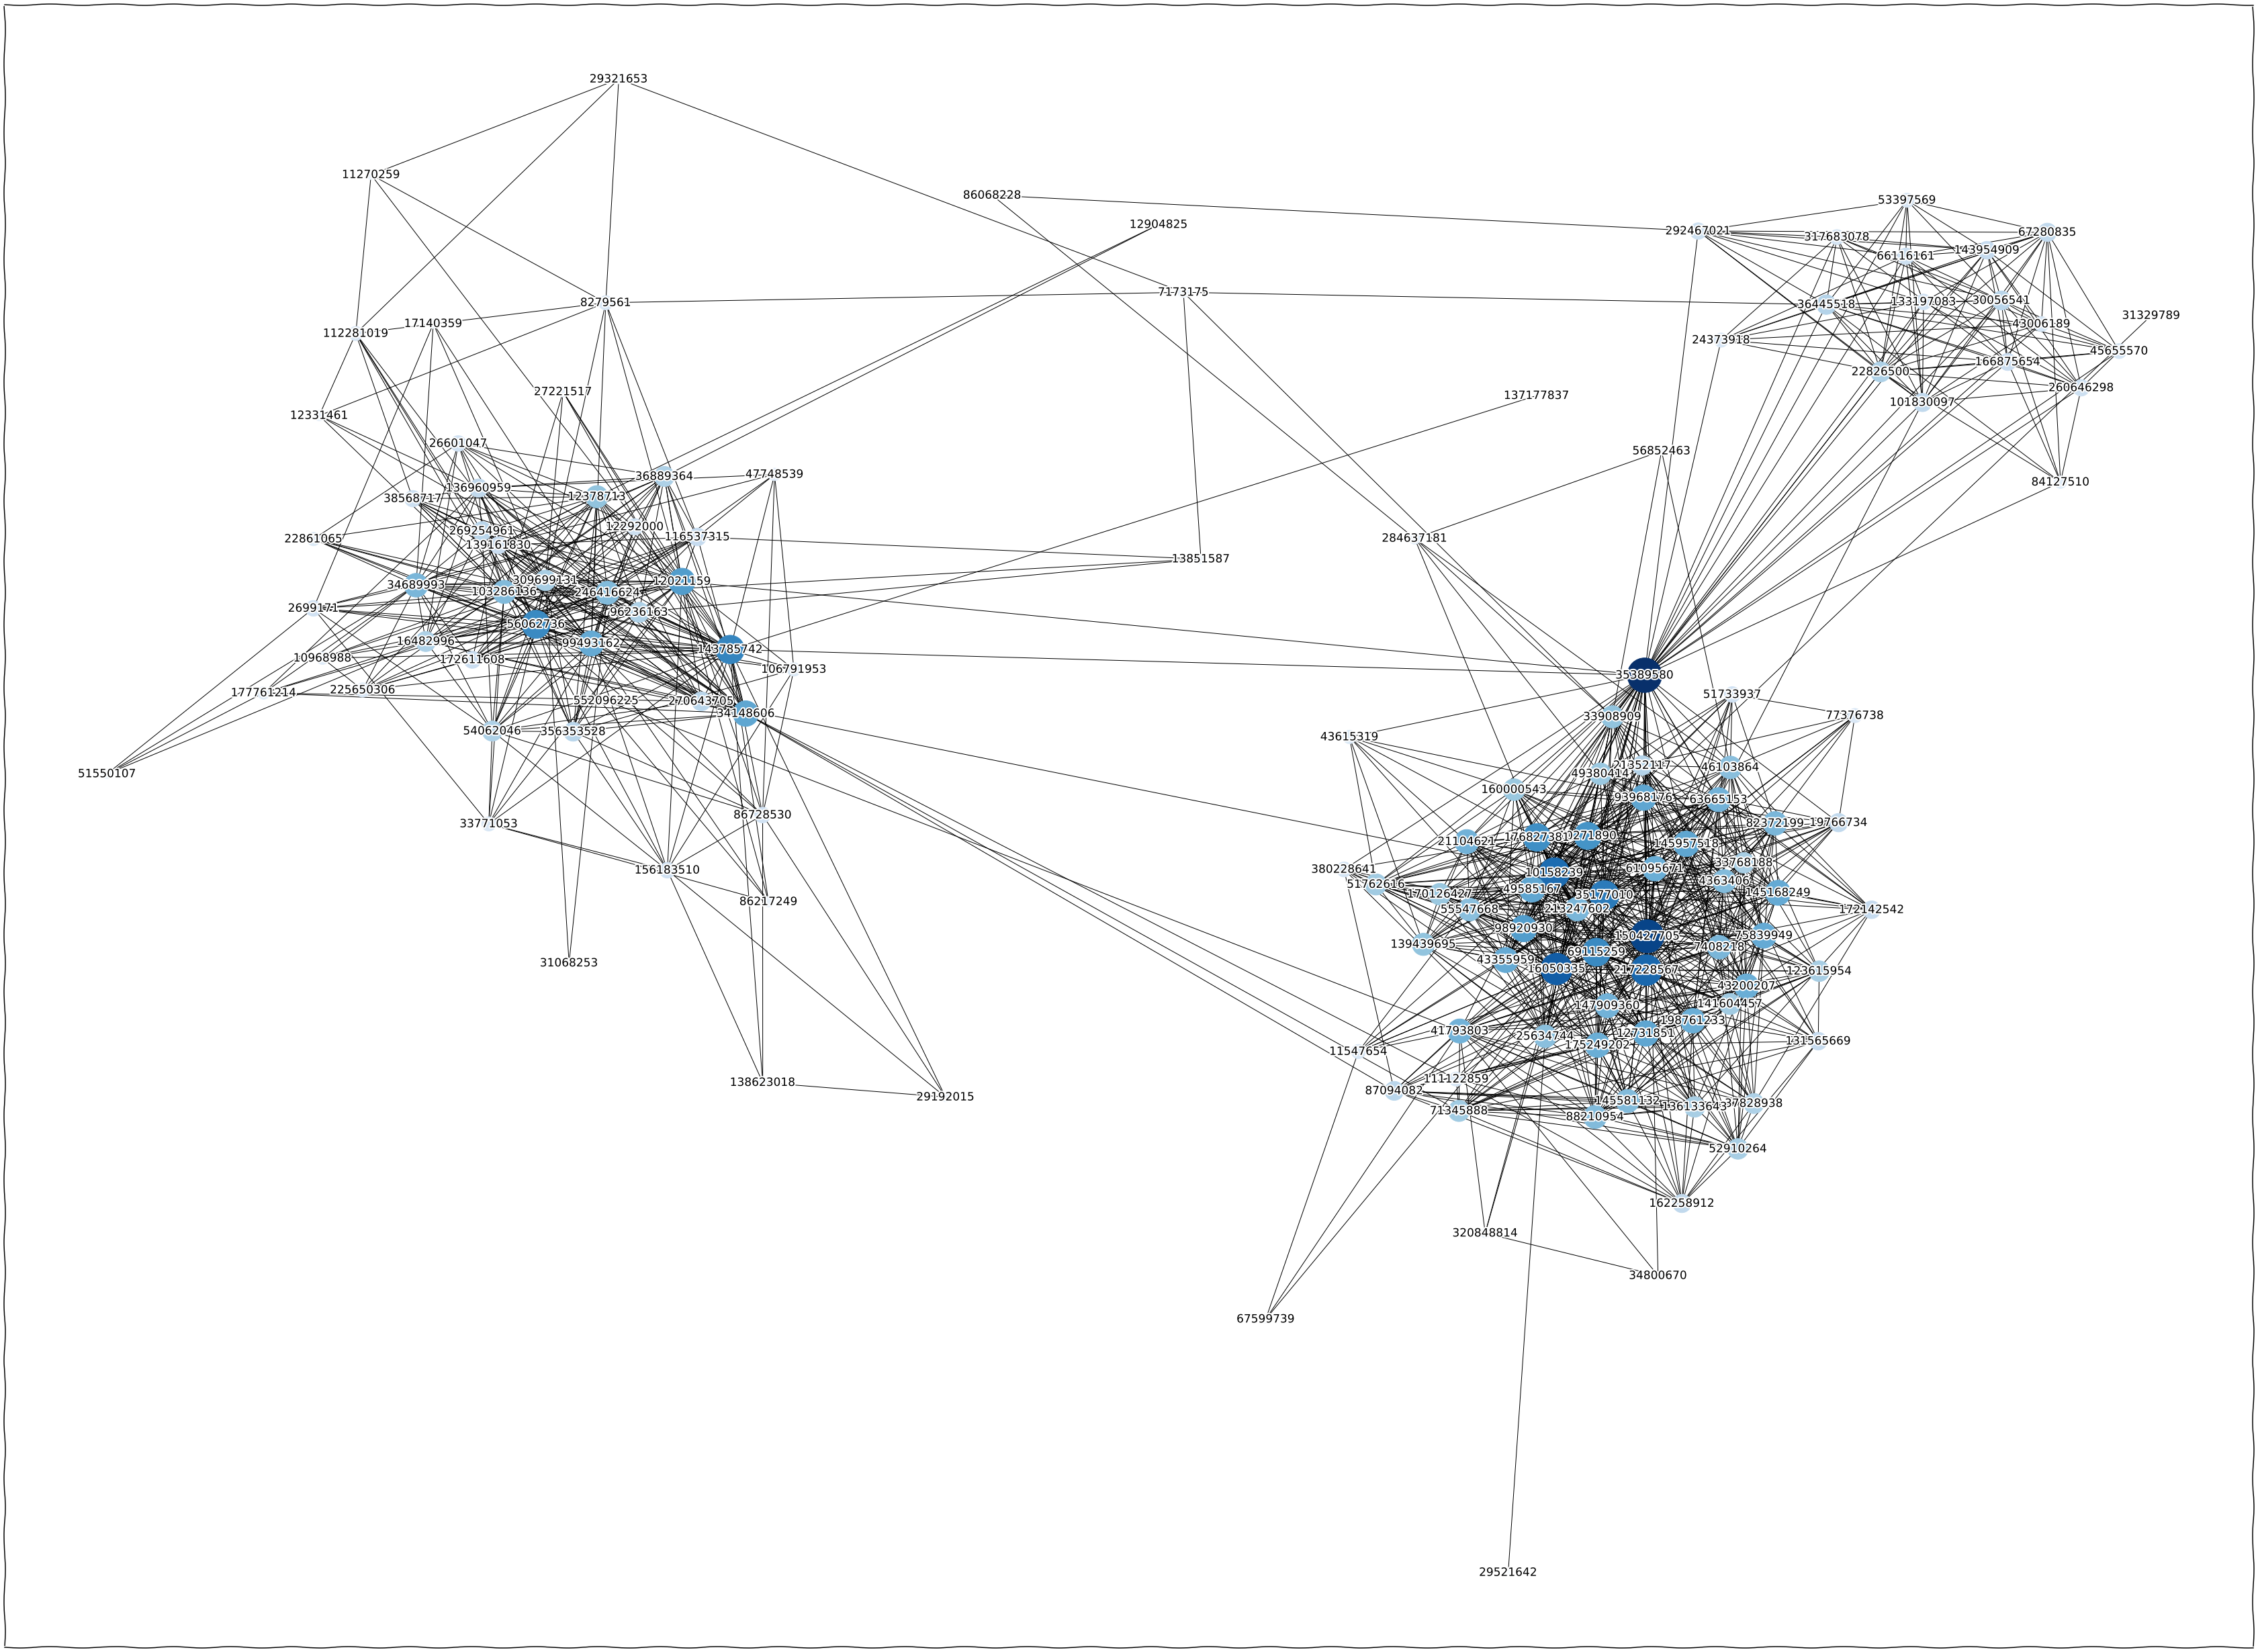

In [5]:
plot_graph(Gmain)

In [6]:
# разделяем на компоненты и удаляем одинокие вершины
G_new = Gmain.copy()
while len(list(nx.connected_components(G_new))) < 3:
    bc = nx.edge_betweenness_centrality(G_new) 
    eg = sorted(bc.items(), key=lambda item: (-item[1], item[0]))[0][0]
    G_new.remove_edges_from([eg])
    nd = list(min(nx.connected_components(G_new), key=len))
    if len(nd) == 1:
        G_new.remove_node(nd[0])

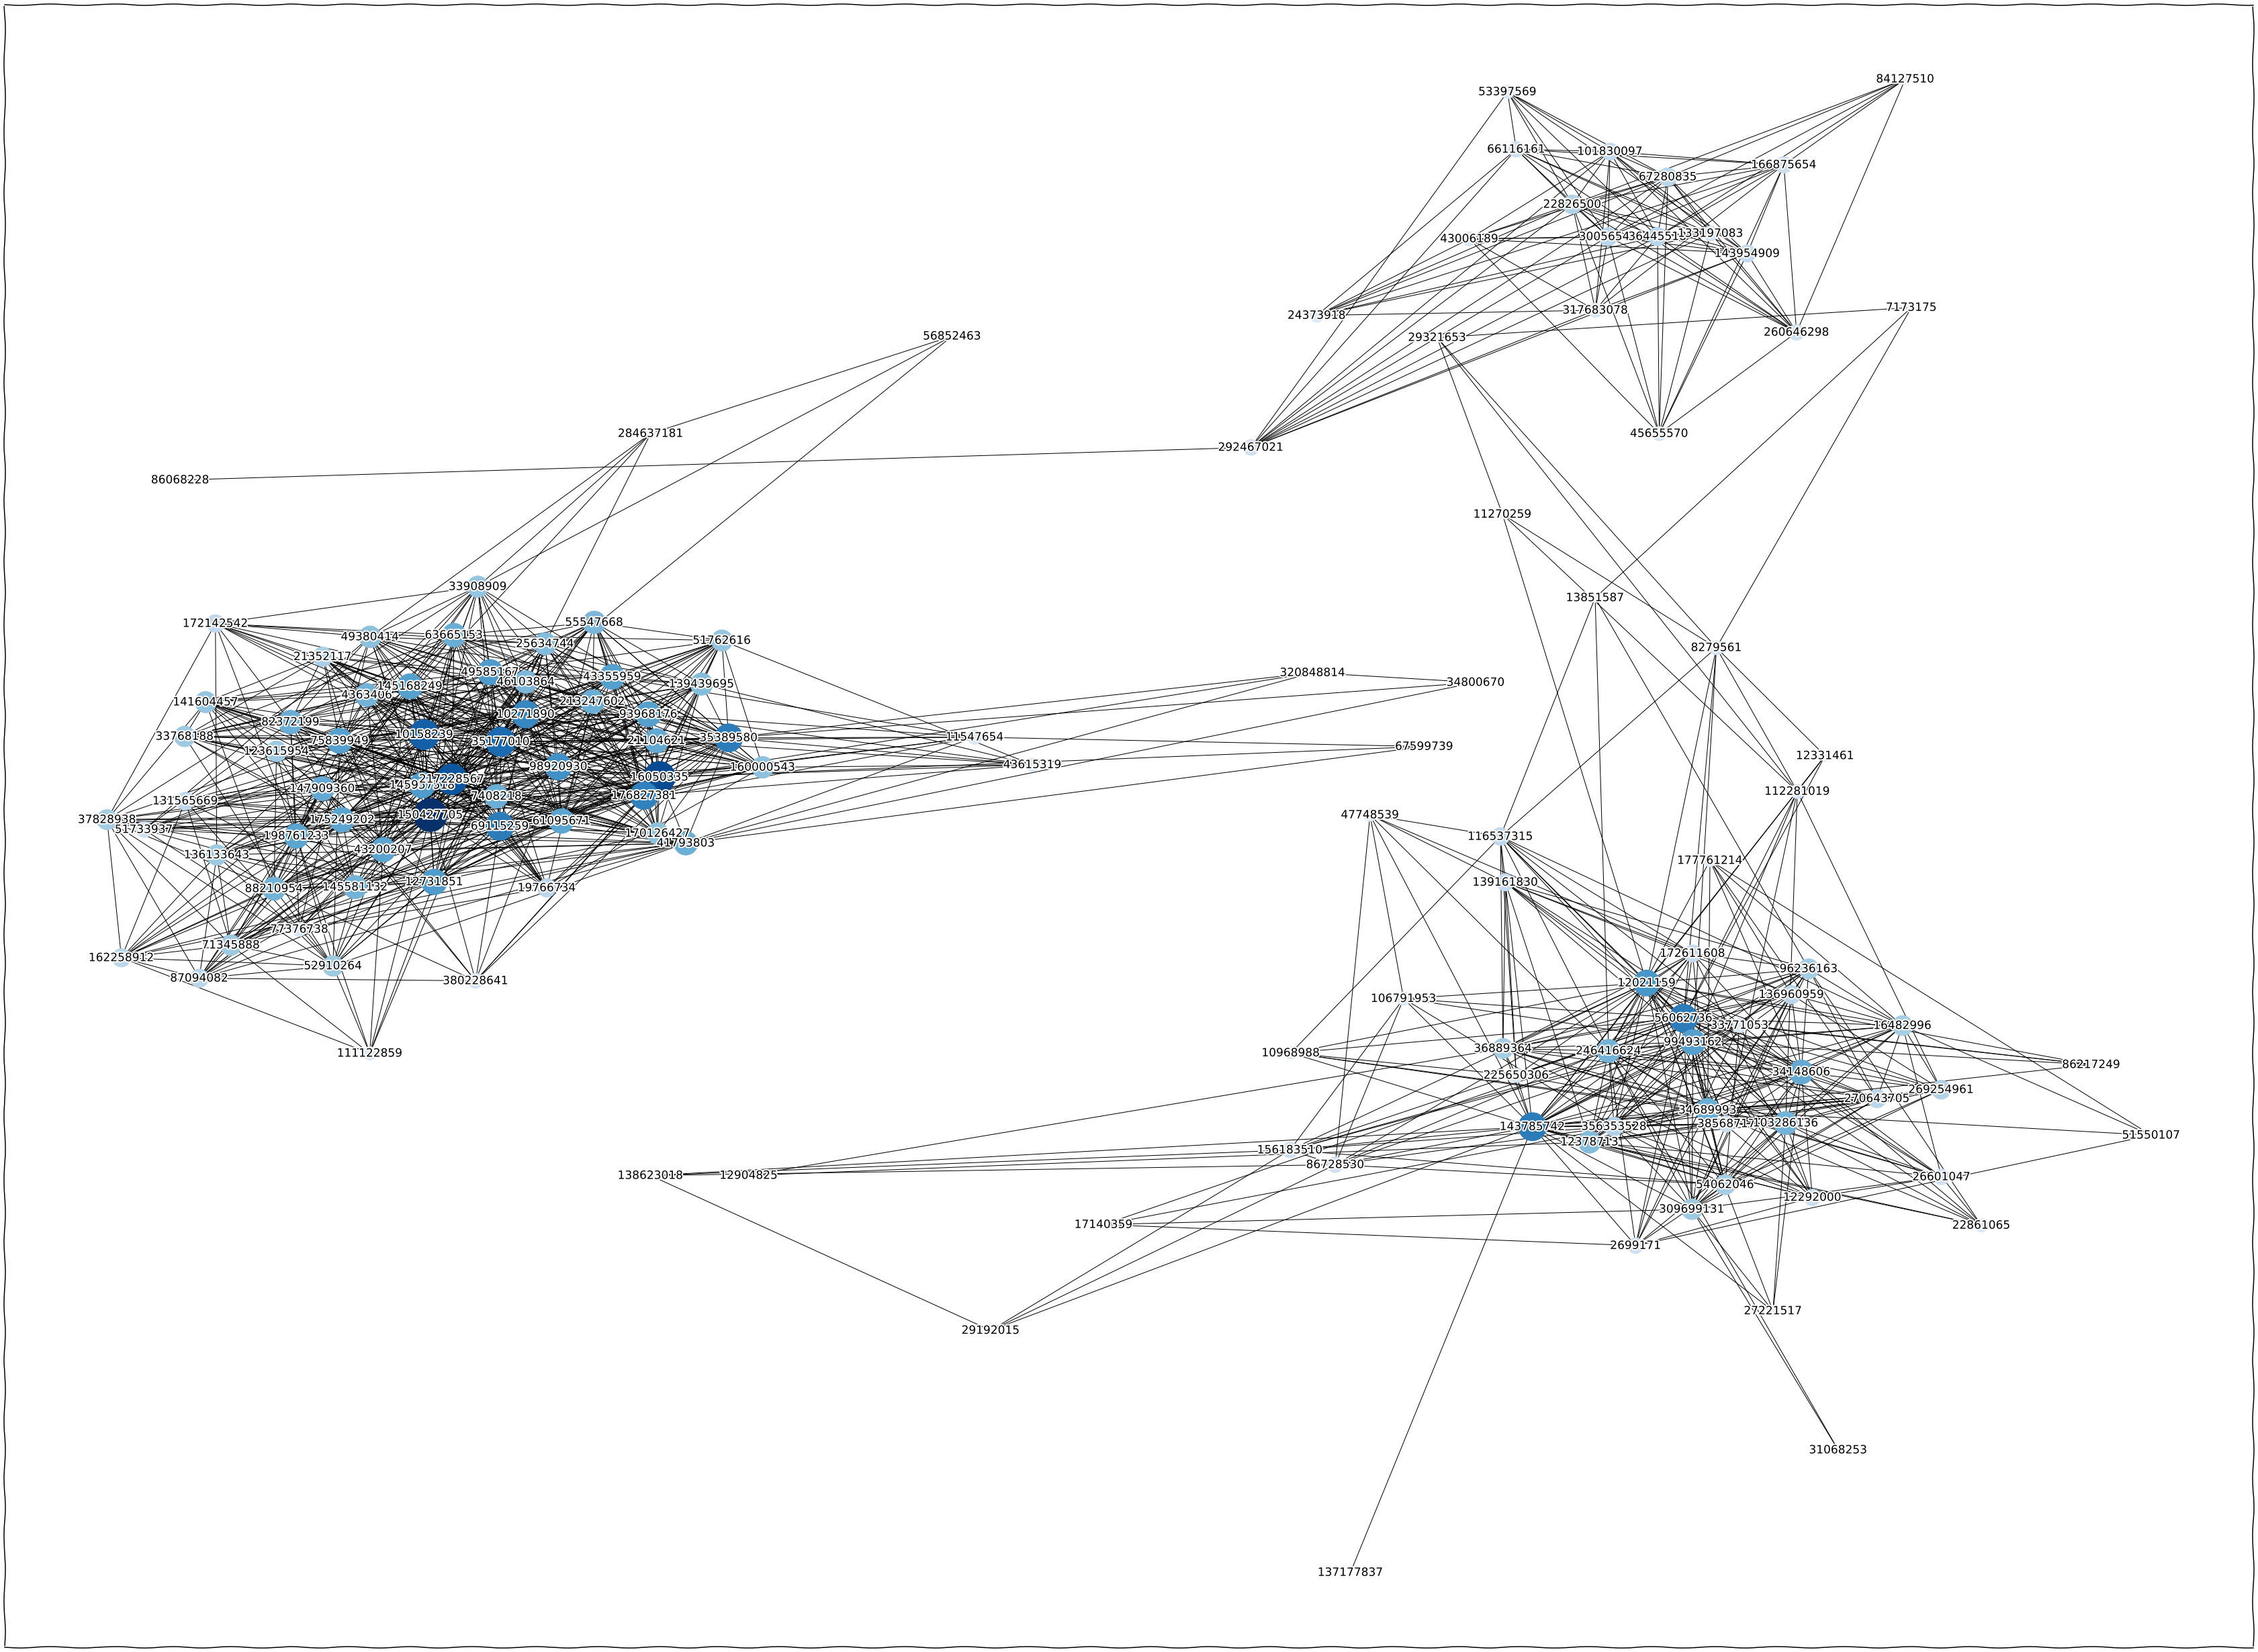

In [7]:
plot_graph(G_new)

In [8]:
cc_first, cc_second, cc_third = nx.connected_components(G_new)

In [9]:
G_first = G_new.subgraph(cc_first)
G_second = G_new.subgraph(cc_second)
G_third = G_new.subgraph(cc_third)

In [10]:
len(G_first), len(G_second), len(G_third)

(50, 64, 18)

В результате разбиения графа были получены 3 компоненты связности количеством вершин: 50, 64 и 18.

**Пол**

* 1 - женщина
* 2 - мужчина

In [11]:
print(sum([i==1 for i in nx.get_node_attributes(G_first, "sex").values()])/len(G_first))
print(sum([i==2 for i in nx.get_node_attributes(G_first, "sex").values()])/len(G_first))

0.62
0.38


In [12]:
print(sum([i==1 for i in nx.get_node_attributes(G_second, "sex").values()])/len(G_second))
print(sum([i==2 for i in nx.get_node_attributes(G_second, "sex").values()])/len(G_second))

0.578125
0.421875


In [13]:
print(sum([i==1 for i in nx.get_node_attributes(G_third, "sex").values()])/len(G_third))
print(sum([i==2 for i in nx.get_node_attributes(G_third, "sex").values()])/len(G_third))

0.5555555555555556
0.4444444444444444


Можно сделать вывод о том, что различий в распределении пола среди 2 и 3 сообществ нет. В первом сообществе девушек чуть больше.

**Количество аудиозаписей**

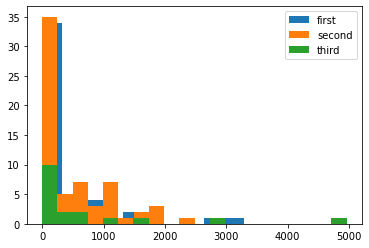

In [14]:
plt.hist([i['audios'] for i in list(nx.get_node_attributes(G_first, "counters").values())], 10, label='first')
plt.hist([i['audios'] for i in list(nx.get_node_attributes(G_second, "counters").values())], 10,label='second')
plt.hist([i['audios'] for i in list(nx.get_node_attributes(G_third, "counters").values())], 20,label='third')
plt.legend();

Разница в распределении количества музыкальных композиций так же отсутствует.

**Родной город**


In [15]:
l_1 = list(nx.get_node_attributes(G_first, "home_town").values())
[[x,l_1.count(x)] for x in set(l_1)]

[['', 6],
 ['Великий Новгород', 1],
 ['СПб', 1],
 ['Балтийск', 1],
 ['Санкт - Петербург', 1],
 ['Радуга', 1],
 ['Санкт-Петербург', 23],
 [None, 10],
 ['Нерюнгри', 1],
 ['Мурманск', 1],
 ['Питер', 1],
 ['Сосновый Бор', 1],
 ['Saint-Petersburg', 1],
 ['Санкт-Петербург, Россия', 1]]

In [16]:
# доля петербуржцев среди друзей указавших родной город
28 / (50-10-6)

0.8235294117647058

В первом сообществе среди людей, указавший родной город, 82% являются петербуржцами.

In [17]:
l_2 = list(nx.get_node_attributes(G_second, "home_town").values())
[[x,l_2.count(x)] for x in set(l_2)]

[['', 14],
 ['Новодвинск', 1],
 ['Ярославль', 1],
 ['Благовещенск', 1],
 ['Черноерковская', 1],
 ['Надым', 1],
 ['Кострома', 1],
 ['Санкт-Петербург, Владивосток', 1],
 ['Санкт-Петербург', 15],
 [None, 8],
 ['Шелупоньград(бывш. Архангельск)', 1],
 ['челябинск', 1],
 ['Ноябрьск', 1],
 ['г.Отрадное', 1],
 ['Невель', 1],
 ['Омск', 2],
 ['Кирово-Чепецк', 1],
 ['Йошкар-Ола', 1],
 ['Ханты-Мансийск', 1],
 ['Архангельск', 1],
 ['Тольятти', 2],
 ['Челябинск', 1],
 ['Самара', 1],
 ['Cерпухов', 1],
 ['Хабаровск', 1],
 ['Корсаков, Таганрог', 1],
 ['Сыктывкар', 1],
 ['Морозовск', 1]]

In [18]:
15 / (64-8-14)

0.35714285714285715

Во втором сообществе среди людей, указавший родной город, только 36% являются петербуржцами.

In [19]:
l_3 = list(nx.get_node_attributes(G_third, "home_town").values())
[[x,l_3.count(x)] for x in set(l_3)]

[['', 7],
 ['Ставрополь', 1],
 ['Астрахань', 1],
 [None, 2],
 ['Белгород', 1],
 ['Сыктывкар', 1],
 ['Оренбург', 1],
 ['Петербург', 1],
 ['Благовещенск', 1],
 ['Омск', 1],
 ['Тольятти', 1]]

In [20]:
1 / (18-7-2)

0.1111111111111111

В третьем сообществе среди людей, указавший родной город, только 11% являются петербуржцами.

Полученные сообщества представляют собой:
* 1 - друзей по школе;
* 2 - друзей из университета, в котором был получен диплом бакалавра;
* 3 - одногруппников из магистратуры.

Единственный признак, который может охарактеризовать сообщества - родной город. Так как я всю жизнь живу в СПб, родной город друзей по школе так же СПб (82% друзей). В университах людей не из СПб гараздо больше. В бакалавриате петербуржцев больше, чем в магистратуре, потому что выпускники петербургских школ, вероятно, будут поступать в Петербург за высшим образованием (36%). Магистратура, в свою очередь, не является обязательной для получения высшего образования, поэтому поступать в нее будут люди, желающие получить дополнительные знания, со всей России в равных количествах (11%). 

### 2. Модель присутствия ребер в графе

In [21]:
from itertools import permutations, combinations
from collections import Counter
import pandas as pd

In [22]:
# возможные ребра в исходном графе
couples = []
for i in combinations(G.nodes, 2):
    couples.append(i)

In [23]:
len(couples)

10296

In [24]:
node1, node2 = zip(*couples)

Получение признаков для модели:

In [25]:
# число общий друзей
def couple_friends(G):
    couples = []
    for node in G.nodes:
        # перестановки используются, чтобы далее было удобно искать пары
        for i in permutations(list(G[node]), 2):
            couples.append(i)
    count_couples = Counter(couples)
    return count_couples

count_couples = dict(couple_friends(G))

In [26]:
len(count_couples)

8276

In [27]:
# разница в количестве друзей
deg = nx.degree(G)

delta_deg = []
for v in couples:
    i, j = v
    x = abs(deg[i] - deg[j])
    delta_deg.append(x)

In [28]:
# пол
dict_sex = nx.get_node_attributes(G, "sex")
sex = []
for v in couples:
    i, j = v
    x = int(dict_sex[i] == dict_sex[j])
    sex.append(x)

In [29]:
# наличие ребра
target = [edge in G.edges for edge in couples]

In [30]:
# подготовка единого df
df = pd.DataFrame()
df['edge'] = couples
df['node1'] = node1
df['node2'] = node2
df.shape

(10296, 3)

In [31]:
df_cc = pd.DataFrame.from_dict(count_couples, orient='index').reset_index()
df_cc.columns=['edge','count_couples']
df_cc.shape

(8276, 2)

In [32]:
df = df.merge(df_cc, how='left', on=['edge'])
df = df.fillna(0)

In [33]:
df['delta_deg'] = delta_deg
df['sex'] = sex
df['target'] = target
df['target'] = df['target'].astype('int')
df = df.set_index('edge')

In [34]:
df.shape

(10296, 6)

In [35]:
df.tail()

node1      node2  count_couples  delta_deg  sex  \
edge                                                                          
(320848814, 380228641)  320848814  380228641            2.0          6    0   
(320848814, 552096225)  320848814  552096225            1.0          3    0   
(356353528, 380228641)  356353528  380228641            0.0          6    0   
(356353528, 552096225)  356353528  552096225            0.0         15    0   
(380228641, 552096225)  380228641  552096225            0.0          9    1   

                        target  
edge                            
(320848814, 380228641)       0  
(320848814, 552096225)       0  
(356353528, 380228641)       0  
(356353528, 552096225)       0  
(380228641, 552096225)       0

In [36]:
# проверка
df[df.target == 1].shape[0] == len(G.edges)

True

### 2.1 Нахождение среди отсутствующих ребер 5 с самой большой согласно модели вероятностью присутствия. 

Вывод о возможности дружбы между полученными парами.

In [37]:
X = df[['count_couples','sex','delta_deg']].values
y = df['target'].values

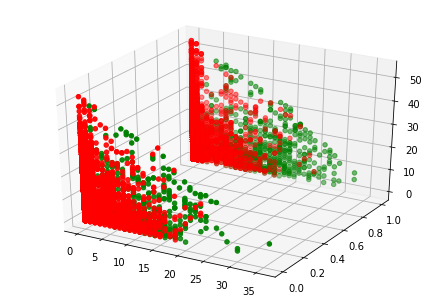

In [38]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(X[y == 0, 0], X[y == 0, 1], X[y == 0, 2], c='red')
ax.scatter(X[y == 1, 0], X[y == 1, 1], X[y == 1, 2], c='green')

plt.show()

In [39]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
import numpy as np

In [40]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
c_values = np.logspace(-2, 3, 500)
logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf)
logit_searcher.fit(X, y)
logit_searcher.C_

array([0.01148472])

In [41]:
C = logit_searcher.C_[0]
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)
logit.fit(X, y)

LogisticRegression(C=0.011484715478402895, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=17, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
y_pr = logit.predict(X)

In [43]:
cm = metrics.confusion_matrix(y, y_pr)
print(cm)

[[8906  230]
 [ 531  629]]


In [44]:
print(classification_report(y, y_pr))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      9136
           1       0.73      0.54      0.62      1160

    accuracy                           0.93     10296
   macro avg       0.84      0.76      0.79     10296
weighted avg       0.92      0.93      0.92     10296



In [45]:
p = logit.predict_proba(X)

In [46]:
df['0'] = pd.DataFrame(p)[0].values
df['1'] = pd.DataFrame(p)[1].values

In [47]:
df[df['target'] == 0].sort_values('0').iloc[:5]

node1      node2  count_couples  delta_deg  sex  \
edge                                                                          
(49585167, 176827381)    49585167  176827381           25.0          5    1   
(10158239, 35389580)     10158239   35389580           24.0         12    1   
(35177010, 145168249)    35177010  145168249           23.0         10    1   
(145581132, 217228567)  145581132  217228567           23.0         18    0   
(10158239, 61095671)     10158239   61095671           23.0         14    0   

                        target         0         1  
edge                                                
(49585167, 176827381)        0  0.005157  0.994843  
(10158239, 35389580)         0  0.006728  0.993272  
(35177010, 145168249)        0  0.010037  0.989963  
(145581132, 217228567)       0  0.010517  0.989483  
(10158239, 61095671)         0  0.011164  0.988836

In [48]:
edge = df[df['target'] == 0].sort_values('0').iloc[:5].index

Для анонимности людей имена решено не выводить.

In [55]:
# 2 года были одногруппницами
nx.get_node_attributes(G,"name")[edge[0][0]], nx.get_node_attributes(G,"name")[edge[0][1]];

In [56]:
# 4 года учились в параллельных группах
nx.get_node_attributes(G,"name")[edge[1][0]], nx.get_node_attributes(G,"name")[edge[1][1]];

In [57]:
# 2 года учились в параллельных группах
nx.get_node_attributes(G,"name")[edge[2][0]], nx.get_node_attributes(G,"name")[edge[2][1]];

In [58]:
# встречались :)
nx.get_node_attributes(G,"name")[edge[3][0]], nx.get_node_attributes(G,"name")[edge[3][1]];

In [59]:
# 4 года учились в параллельных группах 
nx.get_node_attributes(G,"name")[edge[4][0]], nx.get_node_attributes(G,"name")[edge[4][1]];

Все эти люди были знакомы, так как учились вместе 2-4 года, и запросто могли бы дружить.

### 2.2 Восстановление ребер

Случайно выбираются 10% вершин и у них удаляются 20% исходящих ребер. Используется логистическая регрессии для воссстановления этих 10% ребер.

In [54]:
import random

In [55]:
int(len(G.nodes) * 0.1)

14

In [94]:
# 10% вершин
lst_nodes = random.sample(G.nodes, 14)

In [95]:
# 20% ребер для этих вершин
remove_eg = {}
for node in lst_nodes:
    k = int(len(G[node]) * 0.2)
    remove_eg[node] = random.sample(list(G[node]), k)

In [96]:
lst_rem = []
for node in remove_eg:
    lst_rem += [(node,i) for i in remove_eg[node]] + [(i,node) for i in remove_eg[node]]

In [97]:
df_data = df.reset_index().drop(['0','1'], axis=1)

In [98]:
df_data['new_target'] = df_data['target']

In [99]:
df_data.loc[df_data.edge.isin(lst_rem), 'new_target'] = 0

In [100]:
df_test_10 = df_data[(df_data.node1.isin(lst_nodes)) | (df_data.node2.isin(lst_nodes))].copy()

In [101]:
X_test = df_test_10[['count_couples','sex','delta_deg']]
y_test = df_test_10["target"]

In [102]:
X_train = df_data[['count_couples','sex','delta_deg']]
y_train = df_data["new_target"]

In [103]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
c_values = np.logspace(-2, 3, 500)
logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf)
logit_searcher.fit(X_train, y_train)
logit_searcher.C_

array([0.10280732])

In [104]:
C = logit_searcher.C_[0]
clf1 = LogisticRegression(C=C, random_state=17)
clf1.fit(X_train, y_train)

LogisticRegression(C=0.10280732238308653, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=17, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [105]:
# восстановление ребер
y_pr1 = clf1.predict(X_test)

In [106]:
cm = metrics.confusion_matrix(y_test, y_pr1)
print(cm)

[[1652   43]
 [  71  145]]


In [107]:
print(classification_report(y_test, y_pr1))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1695
           1       0.77      0.67      0.72       216

    accuracy                           0.94      1911
   macro avg       0.87      0.82      0.84      1911
weighted avg       0.94      0.94      0.94      1911



Для тестовой выборки из 10% вершин значение f1-score для класса "есть ребро" составляет 72%, что говорит о том, что модель достаточно неплохо обнаруживает ребра. 

In [108]:
df_test_10['pred'] = y_pr1

In [109]:
df_test_10[(df_test_10['new_target'] != df_test_10['target']) & (df_test_10['pred'] == 1)].shape

(29, 9)

In [110]:
df_test_10[(df_test_10['new_target'] != df_test_10['target']) & (df_test_10['pred'] == 0)].shape

(10, 9)

Как видно из результатов, 74% ребер были восстановлены (29 из 39).

### 2.3 Добавление в  модель признака совпадения комьюнити для двух вершин

* Нахождение среди отсутствующих ребер 5 с самой большой согласно модели вероятностью присутствия.

In [112]:
# фича сообщество
comm = []
for v in couples:
    i, j = v
    if (i in cc_first) and (j in cc_first) or (i in cc_second) and (j in cc_second) or (i in cc_third) and (j in cc_third):
        comm.append(1)
    else:
        comm.append(0)

In [114]:
df_data_new = df_data.copy()

In [115]:
df_data_new['comm'] = comm

In [116]:
X = df_data_new[['count_couples','sex','delta_deg','comm']].values
y = df_data_new['target'].values

In [117]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
c_values = np.logspace(-2, 3, 500)
logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf)
logit_searcher.fit(X, y)
logit_searcher.C_

array([0.03725137])

In [118]:
C = logit_searcher.C_[0]
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)
logit.fit(X, y)

LogisticRegression(C=0.03725137300800212, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=17, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [119]:
p = logit.predict_proba(X)

In [120]:
df_data_new['0'] = pd.DataFrame(p)[0].values
df_data_new['1'] = pd.DataFrame(p)[1].values

In [121]:
df_data_new[df_data_new['target'] == 0].sort_values('0').iloc[:5]

edge      node1      node2  count_couples  delta_deg  \
7197   (49585167, 176827381)   49585167  176827381           25.0          5   
1022    (10158239, 35389580)   10158239   35389580           24.0         12   
9956  (150427705, 213247602)  150427705  213247602           22.0         24   
5894   (35177010, 145168249)   35177010  145168249           23.0         10   
9876  (145581132, 217228567)  145581132  217228567           23.0         18   

      sex  target  new_target  comm         0         1  
7197    1       0           0     1  0.012750  0.987250  
1022    1       0           0     1  0.014819  0.985181  
9956    1       0           0     1  0.020866  0.979134  
5894    1       0           0     1  0.020866  0.979134  
9876    0       0           0     1  0.023005  0.976995

In [125]:
edge = df_data_new[df_data_new['target'] == 0].sort_values('0').iloc[:5].edge.values

In [60]:
# 2 года были одногруппницами
nx.get_node_attributes(G,"name")[edge[0][0]], nx.get_node_attributes(G,"name")[edge[0][1]];

In [61]:
# 4 года учились в параллельных группах
nx.get_node_attributes(G,"name")[edge[1][0]], nx.get_node_attributes(G,"name")[edge[1][1]];

In [62]:
# 4 года учились в параллельных группах
nx.get_node_attributes(G,"name")[edge[2][0]], nx.get_node_attributes(G,"name")[edge[2][1]];

In [63]:
# 2 года учились в параллельных группах 
nx.get_node_attributes(G,"name")[edge[3][0]], nx.get_node_attributes(G,"name")[edge[3][1]];

In [64]:
# встречались :)
nx.get_node_attributes(G,"name")[edge[4][0]], nx.get_node_attributes(G,"name")[edge[4][1]];

При добавлении в модель признака принадлежности одному сообществу результаты не изменились.
Все эти люди были знакомы, так как учились вместе 2-4 года, и запросто могли бы дружить.

*  Случайно выбираются 10% вершин и у них удаляются 20% исходящих ребер. Используется логистическая регрессии для воссстановления этих 10% ребер. (используется выборка ребер из п.2.2) 

In [131]:
df_data_new = df_data_new.drop(['0','1'], axis=1)

In [132]:
df_test_10 = df_data_new[(df_data_new.node1.isin(lst_nodes)) | (df_data_new.node2.isin(lst_nodes))].copy()

In [133]:
X_test = df_test_10[['count_couples','sex','delta_deg','comm']]
y_test = df_test_10["target"]

In [134]:
X_train = df_data_new[['count_couples','sex','delta_deg','comm']]
y_train = df_data_new["new_target"]

In [135]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
c_values = np.logspace(-2, 3, 500)
logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf)
logit_searcher.fit(X_train, y_train)
logit_searcher.C_

array([0.17079098])

In [136]:
C = logit_searcher.C_[0]
clf1 = LogisticRegression(C=C, random_state=17)
clf1.fit(X_train, y_train)

LogisticRegression(C=0.17079097973894278, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=17, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [137]:
# восстановление ребер
y_pr1 = clf1.predict(X_test)

In [138]:
cm = metrics.confusion_matrix(y_test, y_pr1)
print(cm)

[[1647   48]
 [  71  145]]


In [139]:
print(classification_report(y_test, y_pr1))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1695
           1       0.75      0.67      0.71       216

    accuracy                           0.94      1911
   macro avg       0.85      0.82      0.84      1911
weighted avg       0.94      0.94      0.94      1911



In [140]:
df_test_10['pred'] = y_pr1

In [141]:
df_test_10[(df_test_10['new_target'] != df_test_10['target']) & (df_test_10['pred'] == 1)].shape

(29, 10)

In [142]:
df_test_10[(df_test_10['new_target'] != df_test_10['target']) & (df_test_10['pred'] == 0)].shape

(10, 10)

Таким образом, добавление в модель признака принадлежности одному сообществу не влияет на результаты. Это может быть связано с тем, что признак "count_couples" - общее количество друзей уже содержит часть информации у круге общения человека (сообществе).

### 3. Интерпретация мер центральности для данного графа

* Выбраны три меры центральности
* Для каждой найдены топ 3 человека
* Вывод о том, почему эти люди оказались в топе.

* ***Центральность по близости***

In [65]:
cc = nx.closeness_centrality(G) 
sorted_by_cc = sorted(cc.items(), key=lambda item: (-item[1], item[0]))

# for i in sorted_by_cc[:3]:
#     print(nx.get_node_attributes(G, "name")[i[0]], i[1])

У данных людей наибольшая центральность по близости, так как они являются моими лучшими друзьями, следовательно, они знакомы с другугими моими друзьями из разных сообществ, а я знакома с их друзьями. Так как центральность по близости характеризует скорость передачи информации, данные узлы являются центральными и могут быстрее взаимодействовать с другими узлами.

* ***Степень влиятельности***

In [66]:
ec = nx.eigenvector_centrality(G)  
sorted_by_ec = sorted(ec.items(), key=lambda item: (-item[1], item[0]))

# for i in sorted_by_ec[:3]:
#     print(nx.get_node_attributes(G, "name")[i[0]], i[1])

У данных людей наибольшая степень влиятельности, так как они являлись старостами в прошлом университете, а также состояли в различных студенческих организациях. За 4 года они установили большое количество связей с людьми, которые так же имеют множество связей; центральность данных вершин зависит от центральностей их соседей.

* ***Центральность по Кацу***

In [67]:
kc = nx.katz_centrality(G, 0.02, max_iter = 1000) 
sorted_by_kc = sorted(kc.items(), key=lambda item: (-item[1], item[0]))

# for i in sorted_by_kc[:3]:
#     print(nx.get_node_attributes(G, "name")[i[0]], i[1])

Результаты чуть схожы со степенью влиятельности. Высокая центральность у данных узлов объясняется тем, что с Дарьей мы учились в двух университетах -> множество общих друзей из разных сообществ, а Ольга и Людмила - старосты, поэтому также имеют множество связей. Так как коэффициент альфа достаточно маленький, только ближайшие "соседи" имеют значение.